In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

# Data loading

## Movie data

In [2]:
# Load films
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
#movies['runtime'].hist()


(81741, 9)


# TO DO

Observed issues: 

The date format is not constant, sometimes it's the year only, sometimes it's yyyy-mm-dd

Box office revenue is not always available: NaN + Should take into account inflation

For language, countries and genres there's a code in addition to the information (can we use it??)

To check : 

Missing values

Outliars: height way too big 

Are their any duplicated when considering number of movies?

Calculate a weighted rating : vote * rating?

### Find data set with budget spent!!!

## Character data

In [3]:
# Load characters
characters_header = ['wikipedia_movie_id','freebase_movie_id','movie_release_date','character_name','actor_birthdate','actor_gender','actor_height_meters','actor_ethnicity_freebase_id','actor_name','actor_age_at_movie_release','freebase_character_actor_map_id','freebase_character_id','freebase_actor_id']
characters = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, names=characters_header)
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
96077,34644206,/m/04j2q2g,1996-07-02,NaN,1945-02-06,M,NaN,NaN,Steven Keats,51.0,/m/0cf_tn1,NaN,/m/02x41qm
168968,5411035,/m/0dknft,1981-03-14,NaN,1952-04-08,F,NaN,NaN,Kaori Momoi,28.0,/m/0jxr4j,NaN,/m/04268m
447192,194664,/m/01bn3l,1994-05-23,Hoagie,1943-01-13,M,2.01,NaN,Richard Moll,51.0,/m/03jt9ns,/m/0hgscyl,/m/03qf9s
351582,503562,/m/02j68v,1991-03-22,NaN,1940-10-19,M,NaN,NaN,Keith McCormack,50.0,/m/0bpjcph,NaN,/m/047qb94
443872,36101329,/m/0k6pl02,2012-04-21,Dale,NaN,M,NaN,NaN,Brad Morris,NaN,/m/0mty8g1,/m/0l07jqd,/m/0l07jqm


freebase_character_actor_map_id ?
movies are referred to by wikipedia id or freebase id
lots of data missing especially for: ethnicity, charcter name (maybe some characters aren't named in movies) , 
different date formats for release date 

## IMDB data

In [4]:
imdb_top_1000 = pd.read_csv('data/imdb/imdb_top_1000.csv', thousands=',')

In [5]:
imdb_top_1000.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


# Cleaning & Pre-processing of data

In [6]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [7]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


In [8]:
# Function to remove encoding: 
remove_encoding = lambda x: np.nan if x == '{}' else \
    [w.replace(' Language', '').replace(' language', '') for w in re.findall(r'"(.*?)"', x)[1::2]]

In [9]:
movies['genres'] = movies['genres'].apply(remove_encoding)
movies['languages'] = movies['languages'].apply(remove_encoding)
movies['countries'] = movies['countries'].apply(remove_encoding)
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]


In [10]:
movies['countries'].apply(np.shape).min()

()

### Clean release dates

In [11]:
# Replace string 'release_date' column with 3 float columns ['release_year','release_month','release_day']

movies['release_date'] = movies['release_date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(movies['release_date'].str.split('-', expand=True).values, columns=['release_year','release_month','release_day']) # Split between days, months and year
movies[['release_year','release_month','release_day']] = release_date
movies = movies.drop('release_date',axis=1)


In [12]:
movies.head()

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08,24
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02,16
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None,None


### Remove data that is out of this world 

In [13]:
def replace_outliers_with_nan(df, col, possible_range):
    df[col] = df[col].apply(lambda x: np.nan if x < possible_range[0] or x > possible_range[1] else x)

#### Movies

In [14]:
possible_movie_runtime_range = [0, 85 * 60] # 85 hours is the Guinness World Record for the longest movie - The Cure for Insomnia

In [15]:
replace_outliers_with_nan(movies, 'runtime', possible_movie_runtime_range)

In [16]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,61286.000000
mean,1.740784e+07,4.799363e+07,93.651871
std,1.098791e+07,1.121753e+08,51.513103
min,3.300000e+02,1.000000e+04,0.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,5100.000000


In [17]:
movies[movies['runtime'] == 0]

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,NaN,0.0,[English],[United States of America],[Short Film],1894,None,None


The real length of Dickson Experimental Sound Film is 17 seconds which rounded to minutes is 0.

#### Characters

Remove age and height that are incorrect or corrupted

In [18]:
possible_age_range = (0, 150)
possible_height_range = (0, 3)

In [19]:
replace_outliers_with_nan(characters, 'actor_age_at_movie_release', possible_age_range)
replace_outliers_with_nan(characters, 'actor_height_meters', possible_height_range)

Add ethnicity labels using the freebase ethnicity ids

In [20]:
ethnicity_freebase_ids = pd.read_csv('handled_data/ethnicities_freebase_ids.csv', index_col=0)

In [21]:
def get_actor_ethnicity_label(row):
    try:
        ethnicity_label = ethnicity_freebase_ids.loc[row['actor_ethnicity_freebase_id'], 'ethnicity_label']
    except:
        ethnicity_label = np.NaN
    return ethnicity_label


In [22]:
characters['actor_ethnicity'] = characters.apply(lambda row: get_actor_ethnicity_label(row),axis=1)

In [23]:
characters

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,actor_ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,unknown
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,NaN
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,English people
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,NaN


In [24]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154809.000000,292175.000000
mean,1.396975e+07,1.748177,37.890901
std,1.079662e+07,0.106249,14.085909
min,3.300000e+02,0.610000,0.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,2.356000,103.000000


### IMDB

In [25]:
imdb_top_1000['Runtime'].str.contains(r'\d+ min').value_counts()

True    1000
Name: Runtime, dtype: int64

In [26]:
imdb_top_1000['Runtime'] = imdb_top_1000['Runtime'].str.extract(r'(\d+) min', expand=False).astype(int)
imdb_top_1000.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


In [27]:
imdb_top_1000.describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,1000.000000,1000.000000,843.000000,1.000000e+03,8.310000e+02
mean,122.891000,7.949300,77.971530,2.736929e+05,6.803475e+07
std,28.093671,0.275491,12.376099,3.273727e+05,1.097500e+08
min,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,103.000000,7.700000,70.000000,5.552625e+04,3.253559e+06
50%,119.000000,7.900000,79.000000,1.385485e+05,2.353089e+07
75%,137.000000,8.100000,87.000000,3.741612e+05,8.075089e+07
max,321.000000,9.300000,100.000000,2.343110e+06,9.366622e+08


In [28]:
imdb_top_1000.dtypes

Poster_Link       object
Series_Title      object
Released_Year     object
Certificate       object
Runtime            int32
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross            float64
dtype: object

To estimate a movie success, we need to both account for the rating 'IMDB_Rating' and to the correponding number of votes 'No_of_Votes'. To do so, we build a new weighted rating based on IMDB standard: 

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 

where:

R = average for the movie (mean) = (Rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed (currently 25088)

C = the mean vote across the whole report (currently 7.94)

<AxesSubplot:xlabel='IMDB_Rating', ylabel='count'>

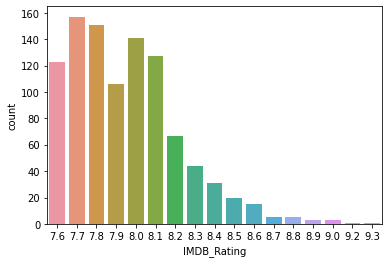

In [29]:
sns.countplot(x='IMDB_Rating', data = imdb_top_1000)

In [30]:
C = imdb_top_1000['IMDB_Rating'].mean()
m = imdb_top_1000['No_of_Votes'].min()

In [31]:
imdb_top_1000['No_of_Votes'].count()

1000

In [32]:
imdb_top_1000['WR'] = (imdb_top_1000['No_of_Votes'] / (imdb_top_1000['No_of_Votes'] + m)) * imdb_top_1000['IMDB_Rating'] + (m / (imdb_top_1000['No_of_Votes'] + m)) * C

In [33]:
imdb_top_1000.sample(5)

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,WR
97,https://m.media-amazon.com/images/M/MV5BOTdiNz...,Requiem for a Dream,2000,A,102,Drama,8.3,The drug-induced utopias of four Coney Island ...,68.0,Darren Aronofsky,Ellen Burstyn,Jared Leto,Jennifer Connelly,Marlon Wayans,766870,3635482.0,8.288890
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,9.180931
11,https://m.media-amazon.com/images/M/MV5BNWIwOD...,Forrest Gump,1994,UA,142,"Drama, Romance",8.8,"The presidencies of Kennedy and Johnson, the e...",82.0,Robert Zemeckis,Tom Hanks,Robin Wright,Gary Sinise,Sally Field,1809221,330252182.0,8.788365
404,https://m.media-amazon.com/images/M/MV5BMzVjNz...,Rain Man,1988,U,133,Drama,8.0,Selfish yuppie Charlie Babbitt's father left a...,65.0,Barry Levinson,Dustin Hoffman,Tom Cruise,Valeria Golino,Gerald R. Molen,473064,178800000.0,7.997447
337,https://m.media-amazon.com/images/M/MV5BMTg5MT...,Serbuan maut 2: Berandal,2014,A,150,"Action, Crime, Thriller",8.0,"Only a short time after the first raid, Rama g...",71.0,Gareth Evans,Iko Uwais,Yayan Ruhian,Arifin Putra,Oka Antara,114316,2625803.0,7.990876


### Merge IMDB database with movie database to have common features

In [34]:
movie_feature = imdb_top_1000.merge(movies, left_on='Series_Title', right_on='name',how='inner')

In [35]:
print(f'There are {movie_feature.shape[0]} common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes {imdb_top_1000.shape[0]} elements and Movie corpus includes {movies.shape[0]}.')


There are 875 common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes 1000 elements and Movie corpus includes 81741.


In [36]:
movie_feature.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'WR',
       'wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

# Exploratory Data Analysis

Looking at the impacts of features on eachother by drawing a correlation heatmap

C:\Users\34683\AppData\Local\Temp/ipykernel_9764/1029419181.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(movie_feature.corr(), annot=True, ax=ax);


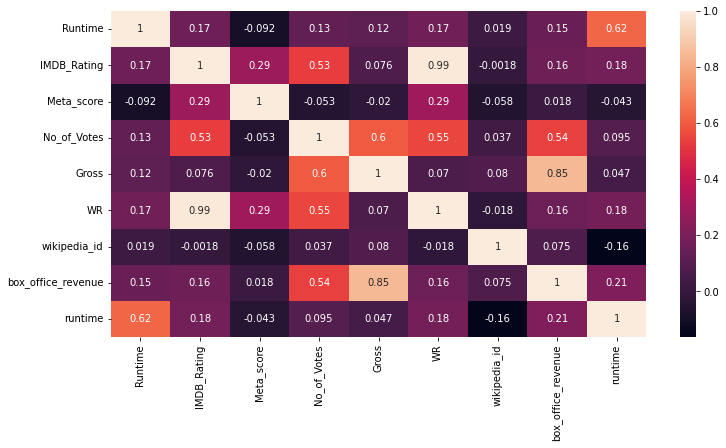

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(movie_feature.corr(), annot=True, ax=ax);


### Impact of release date on success

To assess the impact of release date on success, we need to use the information on 'release_month' for each movie and need to choose a feature for success which can be either the IMDB weighted rating 'WR' or the 'box_office_revenue'. Since 'WR' and 'release_month' are features coming from two different datasets, we need to use the merged dataframe movie_feature which contains only 875. We can then compare the results found with ('WR','release_month') to ('box_office_revenue','release_month') which is based on much more data: 81741. 

-> CHECK CORRELATION BETWEEN RATING AND BOX OFFICE REVENUE

In [38]:
df_release = movie_feature.dropna(how='all', subset=['release_month']) # Remove NaN months

In [39]:
movies['release_month'].describe()

count     42667
unique       12
top          09
freq       4268
Name: release_month, dtype: object

In [40]:
df_release.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'WR',
       'wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [41]:
df_release = movies.dropna(how='all', subset=['release_month']) # Remove NaN months


In [42]:
df_release=df_release.sort_values(by='release_month', ascending=True)

In [43]:
# Plot
plt.figure(figsize=(10,5))
ax7 = sns.barplot(x="release_month", y="WR",data=df_release)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weighted IMDB rating', fontsize=12)
plt.title('Successfulness of Movie Release By Month', fontsize=14)
plt.savefig('CountbyMonth');

ValueError: Could not interpret input 'WR'

<Figure size 720x360 with 0 Axes>

## Popular features in characters

Characters dataset splitted in males and females to easily compare among genders

In [44]:
characters_male = characters[characters['actor_gender'] == 'M']
characters_female = characters[characters['actor_gender'] == 'F']

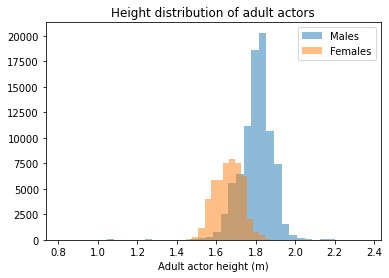

In [45]:
def characters_height_histogram(characters, bins):
    LIMIT_CHILDREN_AGE = 14
    characters_height = characters.dropna(subset=['actor_height_meters'])
    characters_height = characters_height[(characters_height['actor_age_at_movie_release'] > LIMIT_CHILDREN_AGE)]
    plt.hist(characters_height['actor_height_meters'],bins=bins, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Adult actor height (m)')
    plt.title('Height distribution of adult actors')

characters_height_histogram(characters_male, bins=40)
characters_height_histogram(characters_female, bins=25)

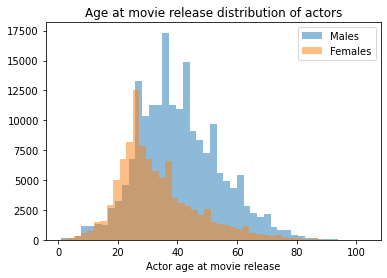

In [46]:
def characters_age_histogram(characters):
    characters_age = characters.dropna(subset=['actor_age_at_movie_release']).sort_values(by=['actor_age_at_movie_release'])
    characters_age = characters_age[characters_age['actor_age_at_movie_release'] > 0]
    plt.hist(characters_age['actor_age_at_movie_release'], bins=45, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Actor age at movie release')
    plt.title('Age at movie release distribution of actors')

characters_age_histogram(characters_male)
characters_age_histogram(characters_female)